# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Evaluate](#Evaluate)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

Feature engineering could continue ad infinitum. Any classifier that implements .predict_proba can generate per-class features that could be useful (calibration can enable predict_proba for models that don't natively implement). These probabilities are all new features. And then two LDA components can be extracted from each of these trios. What's more, you could select any intermediate stage of feature extraction and generate more predicted probabilities or components. And don't forget we have the original FRILL features to tinker with too!

This approach will be limited by how good the FRILL embeddings are without returning to the raw signal. As such, it is worth it to produce such features using the most performant models, as we did with SVM.

This notebook examines the efficacy of bespoke FRILL-based features with GaussianNB.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from datetime import date
from gc import collect as gc_collect
from json import dumps

from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm

# typing
from typing import Any, Dict, List

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    make_scorer,
)

# # other imblearn
# from imblearn.combine import SMOTEENN, SMOTETomek
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
# from imblearn.pipeline import Pipeline

# other sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    PassiveAggressiveClassifier,
    SGDClassifier,
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# param distributions
from lightgbm import LGBMClassifier
from scipy.stats import loguniform, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.93 s


In [4]:
# Location of cross validation data
FEATURES_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 124 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [5]:
# combined_resamplers = lambda: [
#     SMOTEENN(
#         random_state=SEED,
#         smote=SMOTE(random_state=SEED, n_jobs=-1),
#         enn=EditedNearestNeighbours(n_jobs=-1),
#         n_jobs=-1,
#     ),
#     SMOTETomek(
#         random_state=SEED,
#         smote=SMOTE(random_state=SEED, n_jobs=-1),
#         tomek=TomekLinks(n_jobs=-1),
#         n_jobs=-1,
#     ),
#     "passthrough",
# ]

_ = gc_collect()

time: 96.8 ms


In [6]:
def selectfrommodel_grid(before_or_after: str) -> Dict:
    """Returns the parameter grid for SelectFromModel"""
    prefix = f"select_{before_or_after}"
    return {
        prefix: [SelectFromModel(estimator=None, max_features=100)],
        f"{prefix}__estimator": [
            AdaBoostClassifier(
                base_estimator=DecisionTreeClassifier(random_state=SEED),
                random_state=SEED,
            ),
            LGBMClassifier(random_state=SEED, n_jobs=-1, verbose=1),
            ExtraTreesClassifier(n_jobs=-1, random_state=SEED, verbose=1),
            ExtraTreesClassifier(
                n_jobs=-1, random_state=SEED, verbose=1, class_weight="balanced"
            ),
            LinearDiscriminantAnalysis(),
            LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto"),
            LinearSVC(dual=False, verbose=1, random_state=SEED),
            LinearSVC(
                dual=False, verbose=1, random_state=SEED, class_weight="balanced"
            ),
            LogisticRegression(random_state=SEED, max_iter=500, verbose=1, n_jobs=-1),
            LogisticRegression(
                random_state=SEED,
                max_iter=500,
                verbose=1,
                n_jobs=-1,
                class_weight="balanced",
            ),
            PassiveAggressiveClassifier(verbose=1, n_jobs=-1, random_state=SEED),
            PassiveAggressiveClassifier(
                verbose=1, n_jobs=-1, random_state=SEED, class_weight="balanced"
            ),
            RandomForestClassifier(n_jobs=-1, random_state=SEED, verbose=1),
            RandomForestClassifier(
                n_jobs=-1, random_state=SEED, verbose=1, class_weight="balanced"
            ),
            RidgeClassifier(random_state=SEED),
            RidgeClassifier(random_state=SEED, class_weight="balanced"),
            SGDClassifier(verbose=1, n_jobs=-1, random_state=SEED),
            SGDClassifier(
                verbose=1, n_jobs=-1, random_state=SEED, class_weight="balanced"
            ),
        ],
    }


_ = gc_collect()

time: 106 ms


In [7]:
FOLDS = (0, 1, 2, 3, 4)

METRICS = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_weighted": "f1_weighted",
    "geometric_mean": make_scorer(geometric_mean_score),
    "roc_auc_ovo": "roc_auc_ovo",
    "roc_auc_ovr": "roc_auc_ovr",
    "roc_auc_ovo_weighted": "roc_auc_ovo_weighted",
    "roc_auc_ovr_weighted": "roc_auc_ovr_weighted",
}

SCORERS = {
    "accuracy": accuracy_score,
    "adjusted_balanced_accuracy": lambda y_true, y_pred: balanced_accuracy_score(
        y_true, y_pred, adjusted=True
    ),
    "f1_weighted": lambda y_true, y_pred: f1_score(y_true, y_pred, average="weighted"),
    "geometric_mean": geometric_mean_score,
    "roc_auc_ovo": lambda y_true, y_pred: roc_auc_score(
        y_true, y_pred, multi_class="ovo"
    ),
    "roc_auc_ovr": lambda y_true, y_pred: roc_auc_score(
        y_true, y_pred, multi_class="ovr"
    ),
    "roc_auc_ovo_weighted": lambda y_true, y_pred: roc_auc_score(
        y_true, y_pred, average="weighted", multi_class="ovo"
    ),
    "roc_auc_ovr_weighted": lambda y_true, y_pred: roc_auc_score(
        y_true, y_pred, average="weighted", multi_class="ovr"
    ),
}

selectkbest_grid = lambda before_or_after: {
    f"select_{before_or_after}": [SelectKBest()],
    f"select_{before_or_after}__k": list(range(3, 51)),
}

classifier_grids = {
    "bagged": lambda: {
        "clf": [
            BaggingClassifier(
                base_estimator=GaussianNB(), n_jobs=-1, random_state=SEED, verbose=1
            )
        ],
        "clf__base_estimator__var_smoothing": loguniform(1e-20, 1e0),
    },
    "calibrated": lambda: {
        "clf": [
            CalibratedClassifierCV(
                base_estimator=GaussianNB(), method="isotonic", n_jobs=-1
            )
        ],
        "clf__base_estimator__var_smoothing": loguniform(1e-20, 1e0),
    },
    "plain": lambda: {
        "clf": [GaussianNB()],
        "clf__var_smoothing": loguniform(1e-20, 1e0),
    },
}

make_pipeline = lambda temp_dir: Pipeline(
    steps=[
        ("select_before", "passthrough"),
        # ("resample", "passthrough"),
        # ("select_after", "passthrough"),
        ("clf", GaussianNB()),
    ],
    memory=temp_dir,
    verbose=True,
)

_ = gc_collect()

time: 102 ms


# Evaluate

In [8]:
hypersearched_params = {0: [], 1: [], 2: [], 3: [], 4: []}
already_completed: List[int] = []
for fold_num in tqdm(FOLDS):
    reset_seeds(
        SEED := 2021 + fold_num
    )  # varying the seed will test a different grid of hyperparameters each fold
    if fold_num in already_completed:
        continue
    fold_begin = time()

    read_feather = lambda filename: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather"
    )

    # fit hypersearch
    print("fitting hypersearch...")
    with TemporaryDirectory() as temp_dir:
        hypersearch = RandomizedSearchCV(
            estimator=make_pipeline(temp_dir),
            param_distributions=[
                {
                    **selectkbest_grid("before"),
                    # "resample": combined_resamplers(),
                    **classifier_grids["bagged"](),
                },
                {
                    **selectkbest_grid("before"),
                    # "resample": combined_resamplers(),
                    **classifier_grids["calibrated"](),
                },
                {
                    **selectkbest_grid("before"),
                    # "resample": combined_resamplers(),
                    **classifier_grids["plain"](),
                },
                {
                    **selectfrommodel_grid("before"),
                    # "resample": combined_resamplers(),
                    **classifier_grids["bagged"](),
                },
                {
                    **selectfrommodel_grid("before"),
                    # "resample": combined_resamplers(),
                    **classifier_grids["calibrated"](),
                },
                {
                    **selectfrommodel_grid("before"),
                    # "resample": combined_resamplers(),
                    **classifier_grids["plain"](),
                },
            ],
            n_iter=500,
            scoring=METRICS,
            n_jobs=-1,
            refit=False,
            verbose=2,
            random_state=SEED,
            error_score="raise",
        ).fit(
            X_train := read_feather("X_train_FRILL-based_uniQT"),
            y_train := read_feather("y_train_untransformed").iloc[:, 0],
        )

    # save CV results
    df = pd.DataFrame(hypersearch.cv_results_)
    convert_to_string = [
        key
        for key in (
            "param_clf",
            "param_select_before",
            "param_select_before__estimator",
            "params",
        )
        if key in df.columns
    ]  # convert unserializable object columns to str
    df.loc[:, convert_to_string] = df.loc[:, convert_to_string].astype(str)
    df["fold_num"] = fold_num
    df.to_feather(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB_hypersearch.feather"
    )
    del convert_to_string
    _ = gc_collect()

    df = pd.DataFrame(hypersearch.cv_results_)  # reset
    del hypersearch
    _ = gc_collect()
    best_scores = {  # record best scores for selected hyperparameter lookup
        metric: df.loc[:, [f"mean_test_{metric}"]]
        .query(
            # select rows where mean_test_score == (mean_test_score of rank #1)
            f"mean_test_{metric} == {df.query(f'rank_test_{metric} == 1')[f'mean_test_{metric}'].iat[0]}"
        )
        .iat[0, 0]  # then select the top score
        for metric in METRICS.keys()
    }

    # read test data
    X_test = read_feather("X_test_FRILL-based_uniQT")
    y_test = read_feather("y_test_untransformed").iloc[:, 0]
    del read_feather
    _ = gc_collect()

    # evaluate hyperparameters
    print("evaluating hyperparameters...")
    results = {
        "fold_num": [],
        "target_score": [],
        "steps": [],
        "fit_time": [],
        "predict_time": [],
        **{key: [] for key in SCORERS.keys()},
    }
    for metric in best_scores:  # multiple refits
        best_ones = df.query(f"mean_test_{metric} == {best_scores[metric]}")
        if len(best_ones) > 1:  # select rows with best scores
            # break ties
            best_ones = best_ones.sort_values(
                by=[
                    "mean_fit_time",
                    "mean_score_time",
                    "std_fit_time",
                    "std_score_time",
                ],
                ascending=True,
            )

        # obtain best hyperparameters for the metric under consideration
        params: Dict[str, Any] = deepcopy(best_ones.params.iat[0])
        del best_ones
        _ = gc_collect()

        # record scores
        results["target_score"].append(metric)
        if (param_string := str(params)) in (
            str_hypersearched_params := [str(_) for _ in hypersearched_params[fold_num]]
        ):
            print("hyperparameters are redundant")
            # skip redundant fits of individual configurations
            # relevant where one configuration outperforms others and achieves rank #1 for multiple scores
            for key in results.keys():
                if key == "target_score":
                    continue
                results[key].append(
                    deepcopy(results[key][str_hypersearched_params.index(param_string)])
                )
        else:
            print("new hyperparameters found")
            # record new hyperparameter set
            hypersearched_params[fold_num].append(deepcopy(params))
            # log hyperparameters
            with open(
                f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB_hypersearched_params.tsv",
                "a",
            ) as f:
                f.write(
                    "\t".join(
                        [
                            f"{date.today().isoformat()}",
                            f"{time()}",
                            f"{dumps(params, default=str)}\n",
                        ]
                    )
                )
            _ = gc_collect()
            # set pipeline parameters accordingly
            with TemporaryDirectory() as temp_dir:
                pipe = make_pipeline(temp_dir)
                if "select_before__k" in params.keys():
                    pipe.set_params(
                        select_before=SelectKBest(k=params["select_before__k"])
                    )
                    del params["select_before__k"]
                elif "select_before__estimator" in params.keys():
                    pipe.set_params(
                        select_before=SelectFromModel(
                            estimator=params["select_before__estimator"]
                        )
                    )
                    del params["select_before__estimator"]
                del params["select_before"]
                pipe.set_params(clf=params["clf"])
                del params
                _ = gc_collect()

                # fit
                print("fitting...")
                begin = time()
                pipe.fit(X_train, y_train)
                end = time()
                results["fit_time"].append(end - begin)

                # predict
                print("predicting...")
                begin = time()
                y_pred = pipe.predict(X_test)
                end = time()
                results["predict_time"].append(end - begin)
                proba_predict = pipe.predict_proba(X_test)

                # log retained features
                print(
                    "features retained:", features := pipe[:-1].get_feature_names_out()
                )
                with open(
                    f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB_features_retained.tsv",
                    "a",
                ) as f:
                    f.write(
                        "\t".join(
                            [
                                f"{date.today().isoformat()}",
                                f"{time()}",
                                str(fold_num),
                                pipe_steps := str(pipe.steps),
                                f"{features}\n",
                            ]
                        )
                    )
            del features
            del pipe
            _ = gc_collect()

            # save predictions
            pred_df = pd.DataFrame(proba_predict)
            pred_df.columns = pred_df.columns.astype(str)
            pred_df.to_feather(
                f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/best_{metric}_predictions_GaussianNB.feather"
            )
            del pred_df
            _ = gc_collect()

            results["fold_num"].append(fold_num)
            results["steps"].append(pipe_steps)
            del pipe_steps
            _ = gc_collect()
            print("evaluating...")
            # score
            for scorer in SCORERS:
                results[scorer].append(
                    score := SCORERS[scorer](
                        y_test, proba_predict if "roc" in scorer else y_pred
                    )
                )  # roc_auc needs probabilities
                print(f"{scorer}: {score:.3f}")
            del y_pred
            del proba_predict
            del score
            _ = gc_collect()

    # save fold results
    pd.DataFrame(results).to_feather(
        f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB_results.feather"
    )

    del X_train
    del X_test
    del y_train
    del y_test
    del results
    _ = gc_collect()

    print(f"fold {fold_num} completed in {time() - fold_begin:.2f} seconds")
    del fold_begin
    _ = gc_collect()

  0%|          | 0/5 [00:00<?, ?it/s]

fitting hypersearch...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
evaluating hyperparameters...
new hyperparameters found


266

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmposd8yw51',
         steps=[('select_before', SelectKBest(k=4)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmposd8yw51',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmposd8yw51',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

predicting...
features retained: ['spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu']


268

evaluating...
accuracy: 0.664
adjusted_balanced_accuracy: 0.314
f1_weighted: 0.631
geometric_mean: 0.463
roc_auc_ovo: 0.755
roc_auc_ovr: 0.752
roc_auc_ovo_weighted: 0.750
roc_auc_ovr_weighted: 0.739
new hyperparameters found


154

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmprdvv4zvo',
         steps=[('select_before', SelectKBest(k=5)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmprdvv4zvo',
         steps=[('select_before', SelectKBest(k=5)), ('clf', GaussianNB())],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmprdvv4zvo',
         steps=[('select_before', SelectKBest(k=5)), ('clf', GaussianNB())],
         verbose=True)

predicting...
features retained: ['theta_QT-unif_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos'
 'spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu']


241

evaluating...
accuracy: 0.658
adjusted_balanced_accuracy: 0.355
f1_weighted: 0.638
geometric_mean: 0.516
roc_auc_ovo: 0.774
roc_auc_ovr: 0.765
roc_auc_ovo_weighted: 0.764
roc_auc_ovr_weighted: 0.747
hyperparameters are redundant
hyperparameters are redundant
new hyperparameters found


265

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpuovxoygw',
         steps=[('select_before', SelectKBest(k=4)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpuovxoygw',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpuovxoygw',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

predicting...
features retained: ['spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu']


268

evaluating...
accuracy: 0.664
adjusted_balanced_accuracy: 0.314
f1_weighted: 0.631
geometric_mean: 0.463
roc_auc_ovo: 0.755
roc_auc_ovr: 0.752
roc_auc_ovo_weighted: 0.750
roc_auc_ovr_weighted: 0.739
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
fold 0 completed in 2341.45 seconds
fitting hypersearch...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
evaluating hyperparameters...
new hyperparameters found


264

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpt2j58z5r',
         steps=[('select_before', SelectKBest(k=3)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpt2j58z5r',
         steps=[('select_before', SelectKBest(k=3)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpt2j58z5r',
         steps=[('select_before', SelectKBest(k=3)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

predicting...
features retained: ['spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg']


244

evaluating...
accuracy: 0.651
adjusted_balanced_accuracy: 0.318
f1_weighted: 0.633
geometric_mean: 0.507
roc_auc_ovo: 0.765
roc_auc_ovr: 0.761
roc_auc_ovo_weighted: 0.757
roc_auc_ovr_weighted: 0.746
new hyperparameters found


267

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpmujamyo7',
         steps=[('select_before', SelectKBest(k=5)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpmujamyo7',
         steps=[('select_before', SelectKBest(k=5)),
                ('clf',
                 BaggingClassifier(base_estimator=GaussianNB(), n_jobs=-1,
                                   random_state=2022, verbose=1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpmujamyo7',
         steps=[('select_before', SelectKBest(k=5)),
                ('clf',
                 BaggingClassifier(base_estimator=GaussianNB(), n_jobs=-1,
                                   random_state=2022, verbose=1))],
         verbose=True)

predicting...
features retained: ['theta_QT-unif_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos'
 'spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu']


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


334

evaluating...
accuracy: 0.642
adjusted_balanced_accuracy: 0.362
f1_weighted: 0.636
geometric_mean: 0.554
roc_auc_ovo: 0.792
roc_auc_ovr: 0.780
roc_auc_ovo_weighted: 0.777
roc_auc_ovr_weighted: 0.757
hyperparameters are redundant
hyperparameters are redundant
new hyperparameters found


265

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpeicgrkjf',
         steps=[('select_before', SelectKBest(k=5)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpeicgrkjf',
         steps=[('select_before', SelectKBest(k=5)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpeicgrkjf',
         steps=[('select_before', SelectKBest(k=5)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

predicting...
features retained: ['theta_QT-unif_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos'
 'spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu']


332

evaluating...
accuracy: 0.652
adjusted_balanced_accuracy: 0.322
f1_weighted: 0.634
geometric_mean: 0.510
roc_auc_ovo: 0.792
roc_auc_ovr: 0.780
roc_auc_ovo_weighted: 0.777
roc_auc_ovr_weighted: 0.757
hyperparameters are redundant
hyperparameters are redundant
new hyperparameters found


265

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpioy61567',
         steps=[('select_before', SelectKBest(k=3)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpioy61567',
         steps=[('select_before', SelectKBest(k=3)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.3s


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpioy61567',
         steps=[('select_before', SelectKBest(k=3)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

predicting...
features retained: ['spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg']


244

evaluating...
accuracy: 0.651
adjusted_balanced_accuracy: 0.318
f1_weighted: 0.633
geometric_mean: 0.507
roc_auc_ovo: 0.765
roc_auc_ovr: 0.761
roc_auc_ovo_weighted: 0.757
roc_auc_ovr_weighted: 0.746
fold 1 completed in 2181.89 seconds
fitting hypersearch...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
evaluating hyperparameters...
new hyperparameters found


266

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpylop_dp5',
         steps=[('select_before', SelectKBest(k=3)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpylop_dp5',
         steps=[('select_before', SelectKBest(k=3)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpylop_dp5',
         steps=[('select_before', SelectKBest(k=3)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

predicting...
features retained: ['spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg']


244

evaluating...
accuracy: 0.602
adjusted_balanced_accuracy: 0.285
f1_weighted: 0.586
geometric_mean: 0.475
roc_auc_ovo: 0.733
roc_auc_ovr: 0.735
roc_auc_ovo_weighted: 0.733
roc_auc_ovr_weighted: 0.734
new hyperparameters found


267

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpcu0jv9vw',
         steps=[('select_before', SelectKBest(k=6)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpcu0jv9vw',
         steps=[('select_before', SelectKBest(k=6)),
                ('clf',
                 BaggingClassifier(base_estimator=GaussianNB(), n_jobs=-1,
                                   random_state=2023, verbose=1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpcu0jv9vw',
         steps=[('select_before', SelectKBest(k=6)),
                ('clf',
                 BaggingClassifier(base_estimator=GaussianNB(), n_jobs=-1,
                                   random_state=2023, verbose=1))],
         verbose=True)

predicting...
features retained: ['theta_QT-unif_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos'
 'spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu' 'OC_spherical-LDA_pos']


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


357

evaluating...
accuracy: 0.589
adjusted_balanced_accuracy: 0.328
f1_weighted: 0.590
geometric_mean: 0.538
roc_auc_ovo: 0.743
roc_auc_ovr: 0.741
roc_auc_ovo_weighted: 0.739
roc_auc_ovr_weighted: 0.735
hyperparameters are redundant
hyperparameters are redundant
new hyperparameters found


265

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpoanb63tj',
         steps=[('select_before', SelectKBest(k=4)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpoanb63tj',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpoanb63tj',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

predicting...
features retained: ['spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu']


268

evaluating...
accuracy: 0.605
adjusted_balanced_accuracy: 0.281
f1_weighted: 0.585
geometric_mean: 0.462
roc_auc_ovo: 0.737
roc_auc_ovr: 0.738
roc_auc_ovo_weighted: 0.736
roc_auc_ovr_weighted: 0.737
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
fold 2 completed in 1912.05 seconds
fitting hypersearch...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
evaluating hyperparameters...
new hyperparameters found


266

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpay2la15_',
         steps=[('select_before', SelectKBest(k=4)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpay2la15_',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpay2la15_',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

predicting...
features retained: ['spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu']


268

evaluating...
accuracy: 0.612
adjusted_balanced_accuracy: 0.261
f1_weighted: 0.582
geometric_mean: 0.433
roc_auc_ovo: 0.731
roc_auc_ovr: 0.731
roc_auc_ovo_weighted: 0.728
roc_auc_ovr_weighted: 0.724
new hyperparameters found


156

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpmc3dkx5t',
         steps=[('select_before', SelectKBest(k=6)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpmc3dkx5t',
         steps=[('select_before', SelectKBest(k=6)), ('clf', GaussianNB())],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpmc3dkx5t',
         steps=[('select_before', SelectKBest(k=6)), ('clf', GaussianNB())],
         verbose=True)

predicting...
features retained: ['poly6_LDA1'
 'theta_QT-unif_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos'
 'spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu']


255

evaluating...
accuracy: 0.605
adjusted_balanced_accuracy: 0.299
f1_weighted: 0.589
geometric_mean: 0.482
roc_auc_ovo: 0.749
roc_auc_ovr: 0.743
roc_auc_ovo_weighted: 0.741
roc_auc_ovr_weighted: 0.730
hyperparameters are redundant
hyperparameters are redundant
new hyperparameters found


262

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmp9kaq20zr',
         steps=[('select_before', SelectKBest(k=4)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmp9kaq20zr',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmp9kaq20zr',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

predicting...
features retained: ['spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu']


267

evaluating...
accuracy: 0.612
adjusted_balanced_accuracy: 0.261
f1_weighted: 0.582
geometric_mean: 0.433
roc_auc_ovo: 0.731
roc_auc_ovr: 0.731
roc_auc_ovo_weighted: 0.728
roc_auc_ovr_weighted: 0.724
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
fold 3 completed in 1692.02 seconds
fitting hypersearch...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
evaluating hyperparameters...
new hyperparameters found


266

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmprj3es36x',
         steps=[('select_before', SelectKBest(k=3)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmprj3es36x',
         steps=[('select_before', SelectKBest(k=3)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmprj3es36x',
         steps=[('select_before', SelectKBest(k=3)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

predicting...
features retained: ['spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg']


244

evaluating...
accuracy: 0.587
adjusted_balanced_accuracy: 0.297
f1_weighted: 0.572
geometric_mean: 0.490
roc_auc_ovo: 0.742
roc_auc_ovr: 0.746
roc_auc_ovo_weighted: 0.743
roc_auc_ovr_weighted: 0.746
new hyperparameters found


267

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpyjcztmnv',
         steps=[('select_before', SelectKBest(k=4)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpyjcztmnv',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 BaggingClassifier(base_estimator=GaussianNB(), n_jobs=-1,
                                   random_state=2025, verbose=1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmpyjcztmnv',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 BaggingClassifier(base_estimator=GaussianNB(), n_jobs=-1,
                                   random_state=2025, verbose=1))],
         verbose=True)

predicting...
features retained: ['spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu']


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


269

evaluating...
accuracy: 0.591
adjusted_balanced_accuracy: 0.323
f1_weighted: 0.579
geometric_mean: 0.507
roc_auc_ovo: 0.744
roc_auc_ovr: 0.748
roc_auc_ovo_weighted: 0.745
roc_auc_ovr_weighted: 0.747
hyperparameters are redundant
hyperparameters are redundant
new hyperparameters found


265

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmphp2tk3lt',
         steps=[('select_before', SelectKBest(k=4)), ('clf', GaussianNB())],
         verbose=True)

Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmphp2tk3lt',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

fitting...
[Pipeline] ..... (step 1 of 2) Processing select_before, total=   0.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


Pipeline(memory='C:\\Users\\michen\\AppData\\Local\\Temp\\tmphp2tk3lt',
         steps=[('select_before', SelectKBest(k=4)),
                ('clf',
                 CalibratedClassifierCV(base_estimator=GaussianNB(),
                                        method='isotonic', n_jobs=-1))],
         verbose=True)

predicting...
features retained: ['spherical-LDA1' 'spherical-LDA2' 'OC_spherical-LDA_neg'
 'OC_spherical-LDA_neu']


268

evaluating...
accuracy: 0.586
adjusted_balanced_accuracy: 0.291
f1_weighted: 0.568
geometric_mean: 0.478
roc_auc_ovo: 0.744
roc_auc_ovr: 0.748
roc_auc_ovo_weighted: 0.745
roc_auc_ovr_weighted: 0.748
hyperparameters are redundant
hyperparameters are redundant
hyperparameters are redundant
fold 4 completed in 2135.99 seconds
time: 2h 51min 4s


In [9]:
# reset SEED
reset_seeds(SEED := 2021)
_ = gc_collect()

time: 109 ms


In [10]:
# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
_ = gc_collect()

time: 109 ms


In [11]:
results_df = pd.concat(
    [
        pd.read_feather(
            f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB_results.feather"
        )
        for fold_num in (0, 1, 2, 3, 4)
    ]
)

# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/GaussianNB_results_CV5.csv")

results_df.head(10)
_ = gc_collect()

,fold_num,target_score,steps,fit_time,predict_time,accuracy,adjusted_balanced_accuracy,f1_weighted,geometric_mean,roc_auc_ovo,roc_auc_ovr,roc_auc_ovo_weighted,roc_auc_ovr_weighted
0,0,accuracy,"[('select_before', SelectKBest(k=4)), ('clf', CalibratedClassifierCV(base_estimator=GaussianNB(), method='isotonic',\n n_jobs=-1))]",2.620507,0.051102,0.664073,0.313744,0.630749,0.463404,0.754711,0.751563,0.749697,0.739261
1,0,balanced_accuracy,"[('select_before', SelectKBest(k=5)), ('clf', GaussianNB())]",2.096591,0.011009,0.657922,0.354521,0.638305,0.515816,0.774365,0.765148,0.763724,0.747049
2,0,f1_weighted,"[('select_before', SelectKBest(k=4)), ('clf', CalibratedClassifierCV(base_estimator=GaussianNB(), method='isotonic',\n n_jobs=-1))]",2.620507,0.051102,0.664073,0.313744,0.630749,0.463404,0.754711,0.751563,0.749697,0.739261
3,0,geometric_mean,"[('select_before', SelectKBest(k=5)), ('clf', GaussianNB())]",2.096591,0.011009,0.657922,0.354521,0.638305,0.515816,0.774365,0.765148,0.763724,0.747049
4,0,roc_auc_ovo,"[('select_before', SelectKBest(k=4)), ('clf', CalibratedClassifierCV(base_estimator=GaussianNB(), method='isotonic',\n n_jobs=-1))]",2.460042,0.071723,0.664073,0.313744,0.630749,0.463404,0.754711,0.751563,0.749697,0.739261
5,0,roc_auc_ovr,"[('select_before', SelectKBest(k=4)), ('clf', CalibratedClassifierCV(base_estimator=GaussianNB(), method='isotonic',\n n_jobs=-1))]",2.620507,0.051102,0.664073,0.313744,0.630749,0.463404,0.754711,0.751563,0.749697,0.739261
6,0,roc_auc_ovo_weighted,"[('select_before', SelectKBest(k=4)), ('clf', CalibratedClassifierCV(base_estimator=GaussianNB(), method='isotonic',\n n_jobs=-1))]",2.620507,0.051102,0.664073,0.313744,0.630749,0.463404,0.754711,0.751563,0.749697,0.739261
7,0,roc_auc_ovr_weighted,"[('select_before', SelectKBest(k=4)), ('clf', CalibratedClassifierCV(base_estimator=GaussianNB(), method='isotonic',\n n_jobs=-1))]",2.620507,0.051102,0.664073,0.313744,0.630749,0.463404,0.754711,0.751563,0.749697,0.739261
0,1,accuracy,"[('select_before', SelectKBest(k=3)), ('clf', CalibratedClassifierCV(base_estimator=GaussianNB(), method='isotonic',\n n_jobs=-1))]",2.539220,0.044997,0.650642,0.317720,0.633192,0.507080,0.764513,0.760664,0.757471,0.746209
1,1,balanced_accuracy,"[('select_before', SelectKBest(k=5)), ('clf', BaggingClassifier(base_estimator=GaussianNB(), n_jobs=-1, random_state=2022,\n verbose=1))]",2.315441,0.045983,0.642485,0.362188,0.636275,0.554034,0.792162,0.780052,0.777491,0.757196


time: 258 ms



After searching for hyperparameters within the constraints of the specified pipeline and grids/distributions on the train split, we selected the configurations that yielded the best of each mean `target_score` during inner cross validation. For each of these configurations over five pre-determined folds, a new model was trained on the whole training split and scored on the test split. The mean 5-fold test performances of these models (as measured by the respective scorers of the target scores) are compared below.

In [12]:
results_columns = list(SCORERS.keys()) + ["fit_time", "predict_time"]
results_df_ = (
    pd.read_csv(f"{DATA_OUT_FOLDER}/GaussianNB_results_CV5.csv")
    .groupby("target_score")
    .mean()[results_columns]
    .sort_values(by=["fit_time", "predict_time"], ascending=True)
    .sort_values(by=list(SCORERS.keys()), ascending=False)
)
results_df_
results_df_.to_csv(f"{DATA_OUT_FOLDER}/mean_cv5_score_GaussianNB.csv")

_ = gc_collect()

,accuracy,adjusted_balanced_accuracy,f1_weighted,geometric_mean,roc_auc_ovo,roc_auc_ovr,roc_auc_ovo_weighted,roc_auc_ovr_weighted,fit_time,predict_time
target_score,,,,,,,,,,
roc_auc_ovo,0.623745,0.293817,0.600104,0.469225,0.751776,0.749730,0.747250,0.741088,2.215824,0.063506
roc_auc_ovr_weighted,0.622902,0.294964,0.600669,0.473750,0.744929,0.744877,0.742244,0.737985,2.413471,0.053901
accuracy,0.622902,0.294964,0.600669,0.473750,0.744929,0.744877,0.742244,0.737985,2.435486,0.053698
f1_weighted,0.622902,0.294964,0.600669,0.473750,0.744929,0.744877,0.742244,0.737985,2.435486,0.053698
roc_auc_ovo_weighted,0.622902,0.294964,0.600669,0.473750,0.744929,0.744877,0.742244,0.737985,2.435486,0.053698
roc_auc_ovr,0.622902,0.294964,0.600669,0.473750,0.744929,0.744877,0.742244,0.737985,2.435486,0.053698
balanced_accuracy,0.617264,0.333419,0.606363,0.519424,0.760539,0.755425,0.753097,0.743160,2.103153,0.041888
geometric_mean,0.617264,0.333419,0.606363,0.519424,0.760539,0.755425,0.753097,0.743160,2.103153,0.041888


time: 185 ms


In [13]:
catcols = [
    f"param_{catcol}"
    for catcol in (
        "clf",
        "select_before",
        "select_before__estimator",
    )
]

numcols = [
    f"param_{numcol}"
    for numcol in (
        "clf__var_smoothing",
        "clf__base_estimator__var_smoothing",
        "select_before__k",
    )
]

metriccols = [f"mean_test_{metric}" for metric in METRICS.keys()]

_ = gc_collect()

time: 136 ms


# Results

In [14]:
num_rows, num_cols = 2, 4
assert len(METRICS) == num_rows * num_cols
_ = gc_collect()

time: 109 ms


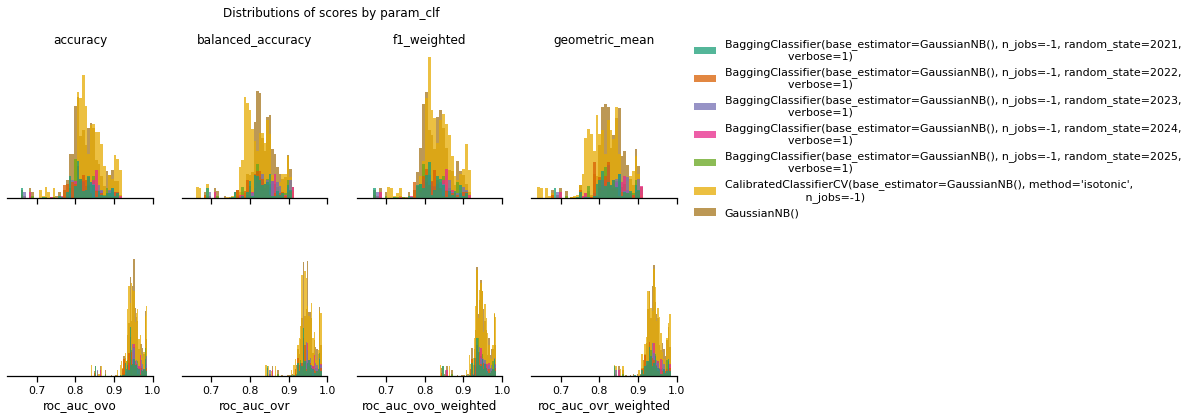

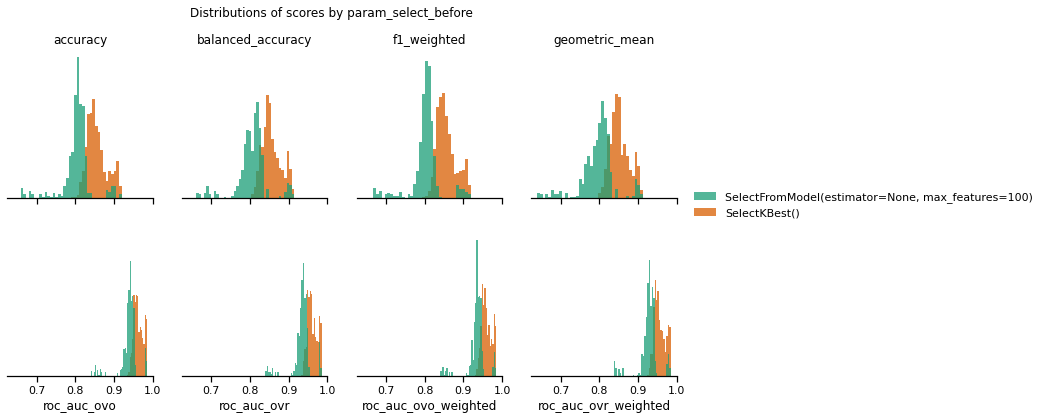

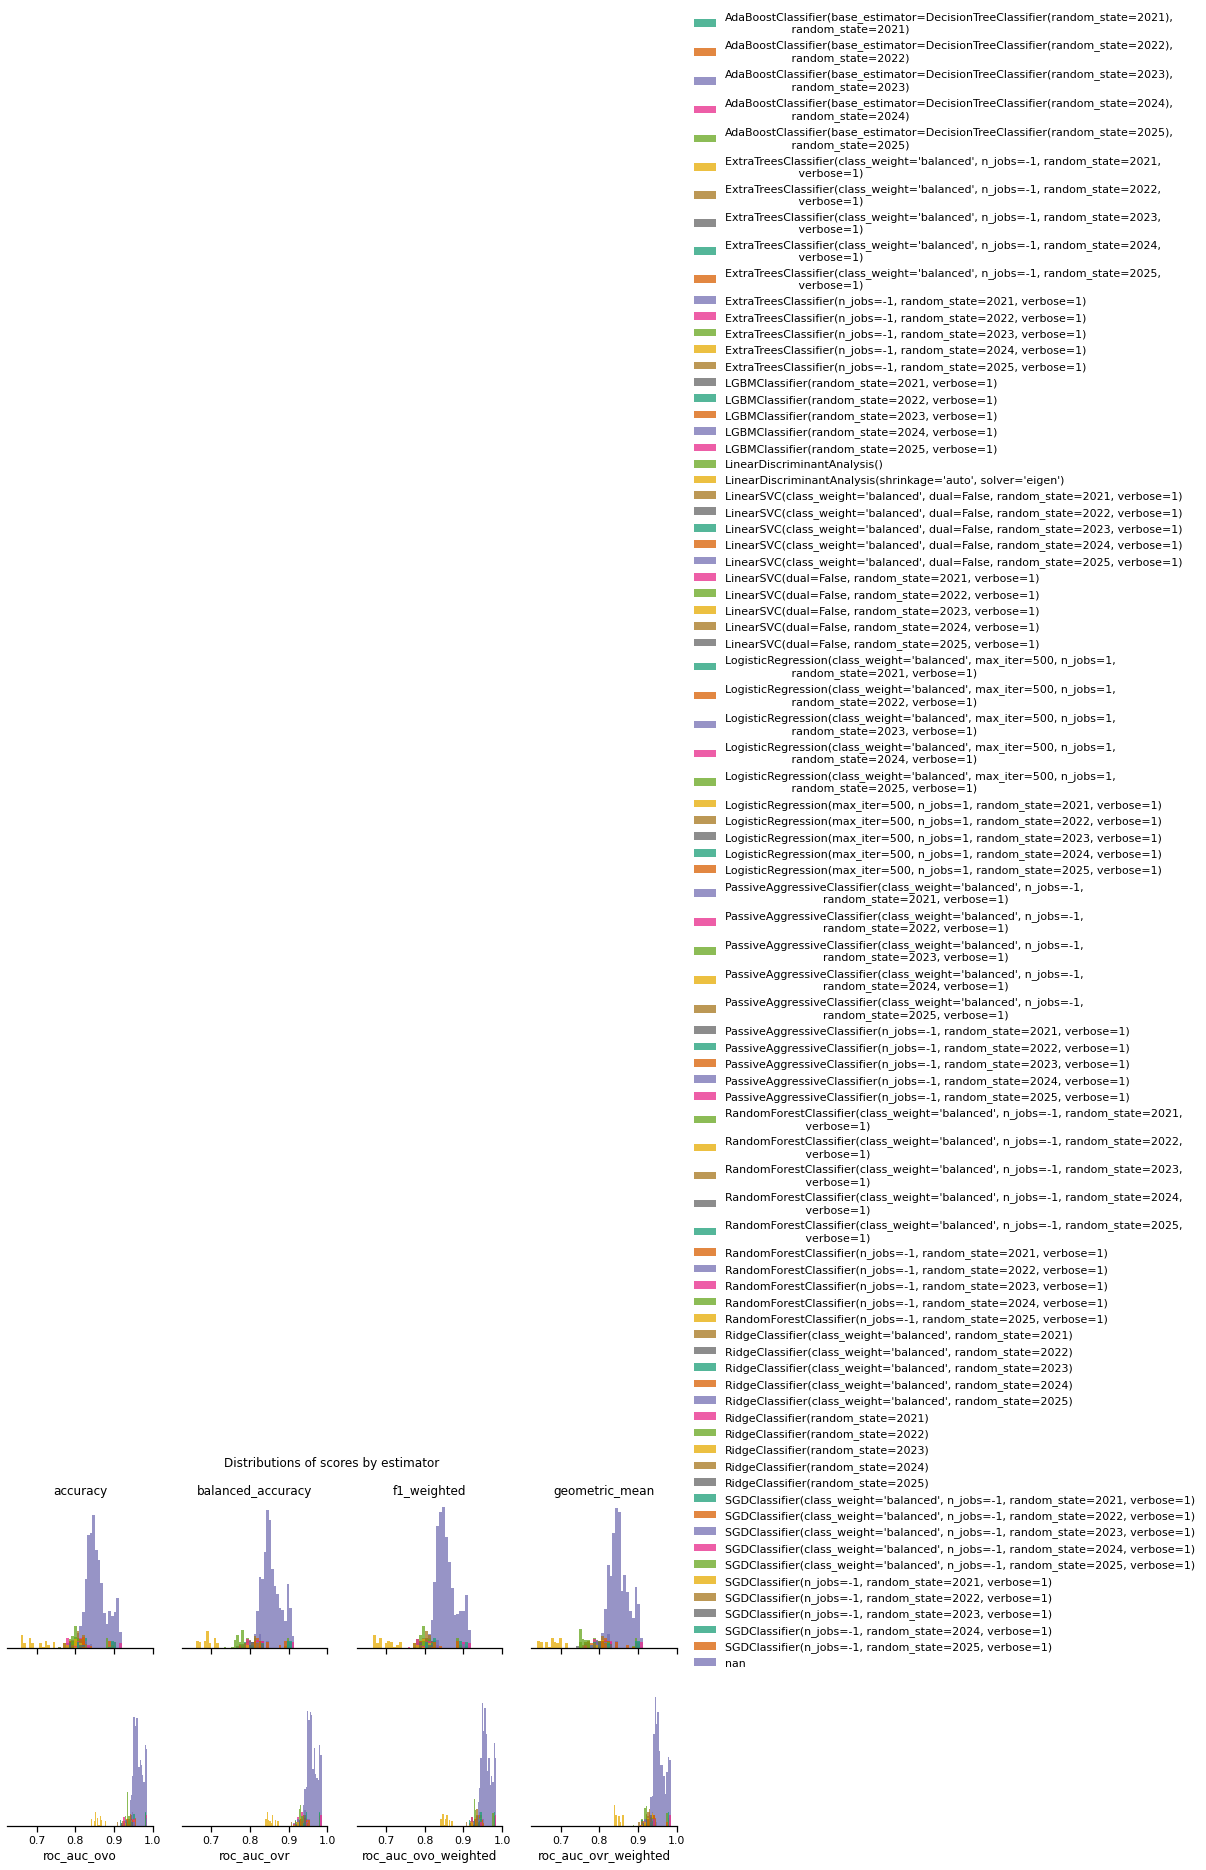

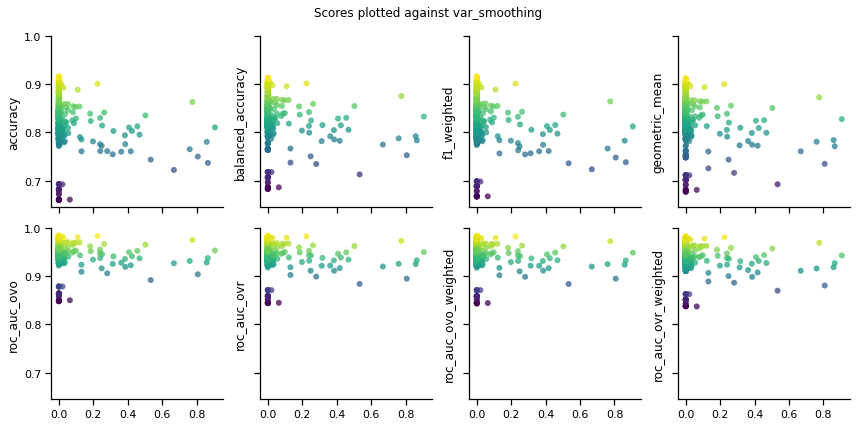

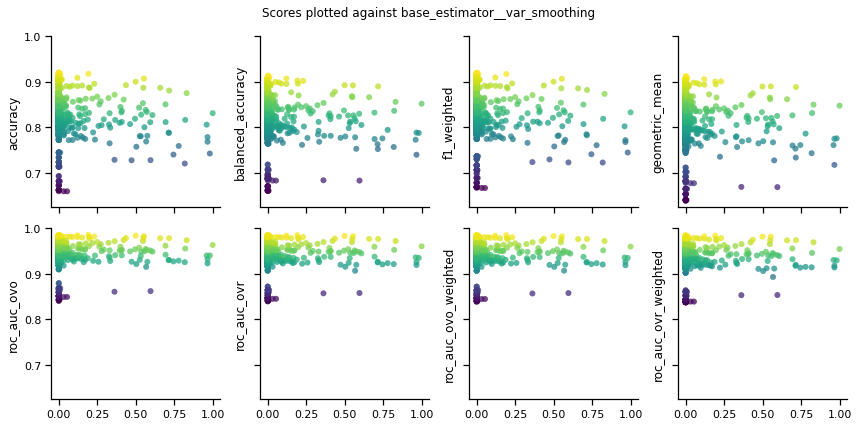

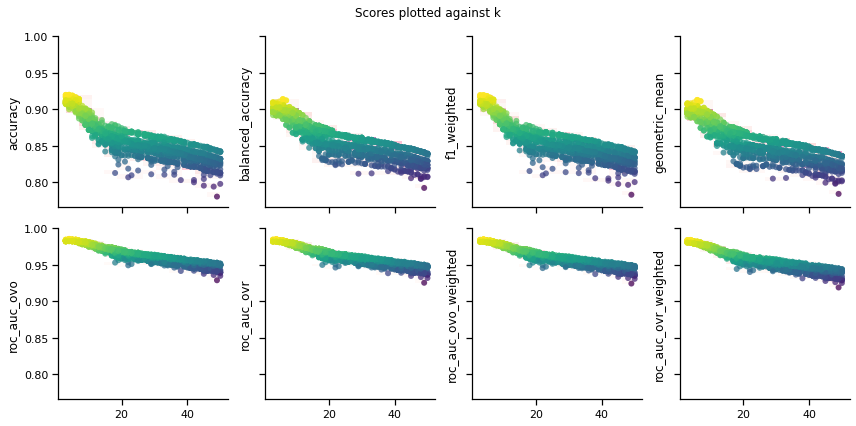

time: 3min 20s


In [15]:
df_ = pd.concat(
    [
        pd.read_feather(
            f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB_hypersearch.feather"
        )
        for fold_num in FOLDS
    ]
).reset_index(drop=True)
# plot categoricals
for catcol in catcols:
    df = (
        df_.loc[:, [catcol] + metriccols].fillna("None").dropna()
    )  # removes disjoint hyperparameter results
    fig, axes = plt.subplots(
        num_rows,
        num_cols,
        sharex=True,
        sharey=True,
        figsize=(num_cols * 3, num_rows * 3),
    )
    hue_order = sorted(df[catcol].unique())
    _ = df[metriccols]
    xmin = _.min().min() - (1.0 - _.max().max())  # lowest score - (1 - highest score)
    # with xmax set at 1.0, this makes equal empty space on either side from the highest and lowest scores
    _ = gc_collect()
    metrics = list(METRICS.keys())
    for row in (0, 1):
        for col in (0, 1, 2, 3):
            ax = axes[row, col]
            _ = sns.histplot(
                data=df,
                x=f"mean_test_{(metric := metrics.pop(0))}",
                hue=catcol,
                palette="Dark2",
                hue_order=hue_order,
                ax=ax,
                linewidth=0,
                alpha=0.75,
            )
            if ax != axes[num_rows - 1, num_cols - 1]:
                _ = ax.get_legend().remove()
            if row:
                _ = ax.set_title("")
                _ = ax.set_xlabel(metric)
            else:
                _ = ax.set_title(metric)
                _ = ax.set_xlabel("")
            _ = ax.set_xlim(xmin=xmin, xmax=1.0)
            _ = ax.set_ylabel("")
            _ = ax.set_yticks([])
    sns.move_legend(
        axes[-1, -1],
        "lower left",
        bbox_to_anchor=(1.05, 1),
        title="",
        frameon=False,
    )
    sns.despine(top=True, right=True, left=True)
    _ = plt.suptitle(f"Distributions of scores by {catcol.split('__', maxsplit=1)[-1]}")
    plt.show()
    del df
    _ = gc_collect()
# plot numerics
for numcol in numcols:
    df = df_.loc[
        :, [numcol] + metriccols
    ].dropna()  # removes disjoint hyperparameter results
    fig, axes = plt.subplots(
        num_rows,
        num_cols,
        sharex=True,
        figsize=(num_cols * 3, num_rows * 3),
    )
    _ = df[metriccols]
    ymin = _.min().min() - (1.0 - _.max().max())  # lowest score - (1 - highest score)
    # with ymax set at 1.0, this makes equal empty space on either side from the highest and lowest scores
    _ = gc_collect()
    metrics = list(METRICS.keys())
    for row in (0, 1):
        for col in (0, 1, 2, 3):
            ax = axes[row, col]
            _ = sns.histplot(
                data=df,
                x=numcol,
                y=(y := f"mean_test_{(metric := metrics.pop(0))}"),
                cmap="RdPu",
                ax=ax,
                linewidth=0,
                alpha=0.5,
                legend=False,
                kde=True,
            )
            _ = sns.scatterplot(
                data=df,
                x=numcol,
                y=y,
                hue=y,
                palette="viridis",
                ax=ax,
                linewidth=0,
                alpha=0.75,
                legend=False,
            )
            _ = ax.set_xlabel("")
            if col:
                _ = ax.set_yticklabels([])
            _ = ax.set_ylim(ymin=ymin, ymax=1.0)
            _ = ax.set_ylabel(metric)
    sns.despine(top=True, right=True)
    _ = plt.suptitle(f"Scores plotted against {numcol.split('__', maxsplit=1)[-1]}")
    plt.tight_layout()
    plt.show()
    del df
    _ = gc_collect()
del df_
_ = gc_collect()

# Discussion

Although best performance may not be achieved through naively including all crafted features, structural multicollinearity doesn't seem to be too much of a problem.

Resampling is an expensive procedure to tune. We may have to focus on other parts of the pipeline first. After those configurations are settled, we can try maybe one or two resampling approaches and hope one of them boosts performance. Again, it will be difficult to find the best method; rather, we should aim to find a good method.

The inner CV hyperparameter search likely overfits because of speaker leakage. However, there is no speaker leakage in the outer folds. Although the cross-validated scores should be reliable, the hyperparameters found may not be optimal. This will be less of an issue when training the full prototype, however, as hyperparameter search will be cross-validated over the entire dataset rather than a single prepared (no speaker leakage) fold at a time (non-nested hyperparameter search).

For SelectKBest, < 20 features may be appropriate. SelectFromModel is only efficacious with certain models. The best accuracy is better than ExtraTrees, but ExtraTrees actually got higher AUROC. A uniform sampling distribution may be better for var_smoothing.

Some of the graphics are overplotted.

AdaBoost may be good for feature selection.

In [16]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 10475.804227352142 s
time: 141 ms


[^top](#Contents)

In [86]:
df_ = pd.concat(
    [
        pd.read_feather(
            f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB_hypersearch.feather"
        )
        for fold_num in FOLDS
    ]
).reset_index(drop=True)
df_.loc[
    df_.param_select_before__estimator.str.contains("random_state"),
    "param_select_before__estimator",
] = df_.loc[
    df_.param_select_before__estimator.str.contains("random_state"),
    "param_select_before__estimator",
].str.replace(
    r"202[1-5]", r"SEED"
)
df_ = df_.groupby("param_select_before__estimator").mean()
df_ = df_.loc[df_.index != "nan"]
df_
df_.columns

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/217783693.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  ] = df_.loc[


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__base_estimator__var_smoothing,param_clf__var_smoothing,param_select_before__k,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_balanced_accuracy,split1_test_balanced_accuracy,split2_test_balanced_accuracy,split3_test_balanced_accuracy,split4_test_balanced_accuracy,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_test_geometric_mean,split1_test_geometric_mean,split2_test_geometric_mean,split3_test_geometric_mean,split4_test_geometric_mean,mean_test_geometric_mean,std_test_geometric_mean,rank_test_geometric_mean,split0_test_roc_auc_ovo,split1_test_roc_auc_ovo,split2_test_roc_auc_ovo,split3_test_roc_auc_ovo,split4_test_roc_auc_ovo,mean_test_roc_auc_ovo,std_test_roc_auc_ovo,rank_test_roc_auc_ovo,split0_test_roc_auc_ovr,split1_test_roc_auc_ovr,split2_test_roc_auc_ovr,split3_test_roc_auc_ovr,split4_test_roc_auc_ovr,mean_test_roc_auc_ovr,std_test_roc_auc_ovr,rank_test_roc_auc_ovr,split0_test_roc_auc_ovo_weighted,split1_test_roc_auc_ovo_weighted,split2_test_roc_auc_ovo_weighted,split3_test_roc_auc_ovo_weighted,split4_test_roc_auc_ovo_weighted,mean_test_roc_auc_ovo_weighted,std_test_roc_auc_ovo_weighted,rank_test_roc_auc_ovo_weighted,split0_test_roc_auc_ovr_weighted,split1_test_roc_auc_ovr_weighted,split2_test_roc_auc_ovr_weighted,split3_test_roc_auc_ovr_weighted,split4_test_roc_auc_ovr_weighted,mean_test_roc_auc_ovr_weighted,std_test_roc_auc_ovr_weighted,rank_test_roc_auc_ovr_weighted,fold_num
param_select_before__estimator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=SEED),\n random_state=SEED)",12.705139,2.598147,0.575862,0.177010,0.003333,0.000556,NaN,0.890823,0.885531,0.889318,0.883026,0.935156,0.896771,0.022523,37.453333,0.879862,0.874007,0.883899,0.905234,0.946240,0.897848,0.029180,26.813333,0.890669,0.885002,0.888915,0.884244,0.935508,0.896868,0.022626,36.653333,0.878929,0.872308,0.881456,0.902603,0.945748,0.896209,0.029728,25.720000,0.976304,0.976814,0.977873,0.981668,0.994419,0.981415,0.007444,34.186667,0.975152,0.975639,0.976286,0.979721,0.993878,0.980135,0.007740,34.840000,0.974981,0.975340,0.975798,0.979560,0.993955,0.979927,0.007876,34.600000,0.972485,0.973089,0.973643,0.976679,0.993356,0.977850,0.008635,34.573333,1.973333
"ExtraTreesClassifier(class_weight='balanced', n_jobs=-1, random_state=SEED,\n verbose=1)",6.421439,0.614081,2.680856,0.565505,0.012946,0.021707,NaN,0.813322,0.798019,0.840398,0.709195,0.793933,0.790974,0.048525,447.112903,0.802790,0.788477,0.854377,0.722060,0.815418,0.796624,0.048098,423.919355,0.814017,0.797476,0.841153,0.711960,0.795660,0.792053,0.047807,443.016129,0.800691,0.784770,0.851087,0.707513,0.812693,0.791351,0.052056,409.935484,0.931152,0.927032,0.956800,0.876982,0.935691,0.925531,0.028196,469.500000,0.928757,0.924450,0.953409,0.873458,0.931815,0.922378,0.028320,469.483871,0.928264,0.923744,0.953134,0.872480,0.931860,0.921897,0.028547,468.322581,0.922724,0.918410,0.949052,0.868611,0.926618,0.917083,0.028621,466.677419,2.241935
"ExtraTreesClassifier(n_jobs=-1, random_state=SEED, verbose=1)",5.145815,0.613730,2.508214,0.507834,0.030663,0.001921,NaN,0.818879,0.803572,0.847986,0.720248,0.798586,0.797854,0.046556,418.640000,0.805207,0.790441,0.856757,0.727611,0.820622,0.800128,0.046969,397.586667,0.819039,0.803036,0.848603,0.722866,0.800368,0.798783,0.045730,412.946667,0.802923,0.786774,0.854057,0.712760,0.817963,0.794895,0.051113,385.320000,0.935029,0.929548,0.958825,0.887037,0.938541,0.929796,0.025911,455.933333,0.932548,0.927035,0.955694,0.883602,0.933981,0.926572,0.025993,453.720000,

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_clf__base_estimator__var_smoothing', 'param_clf__var_smoothing',
       'param_select_before__k', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy', 'split0_test_balanced_accuracy',
       'split1_test_balanced_accuracy', 'split2_test_balanced_accuracy',
       'split3_test_balanced_accuracy', 'split4_test_balanced_accuracy',
       'mean_test_balanced_accuracy', 'std_test_balanced_accuracy',
       'rank_test_balanced_accuracy', 'split0_test_f1_weighted',
       'split1_test_f1_weighted', 'split2_test_f1_weighted',
       'split3_test_f1_weighted', 'split4_test_f1_weighted',
       'mean_test_f1_weighted', 'std_test_f1_weighted',
       'rank_test_f1_weighted', 'split0_test_geometric_mean',
       'split1_test_geometric_mean', 'split2_test_geo

time: 151 ms


In [87]:
def plot_estimator_score(score: str, df: pd.DataFrame = df_) -> None:
    plt.figure(figsize=(5, 10))
    X = f"mean_test_{score}"
    df = df.sort_values(X, ascending=False)
    sns.barplot(
        data=df,
        x=X,
        y=df.index,
    )
    sns.despine()
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 433 ms


C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


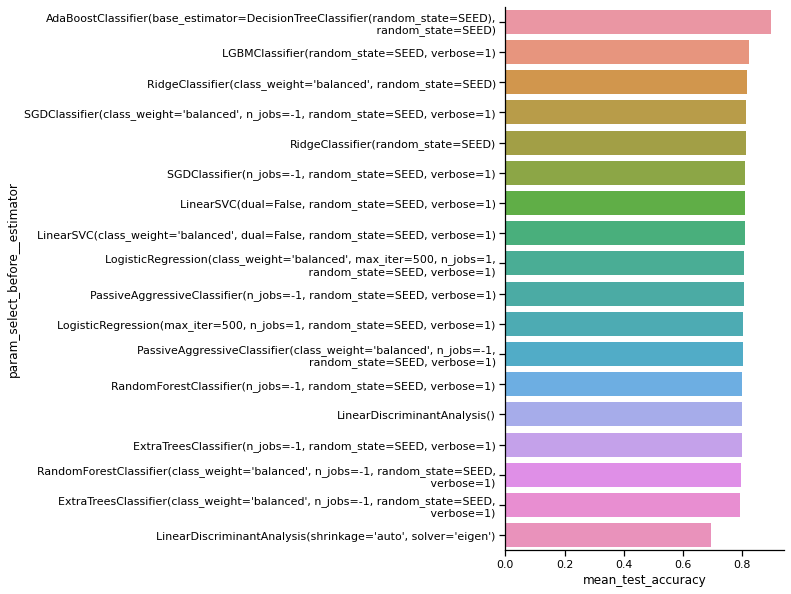

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


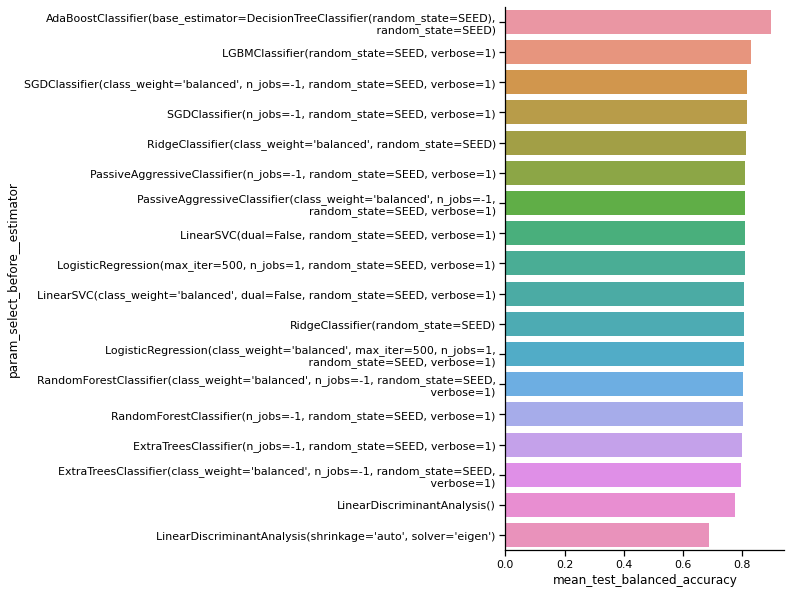

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


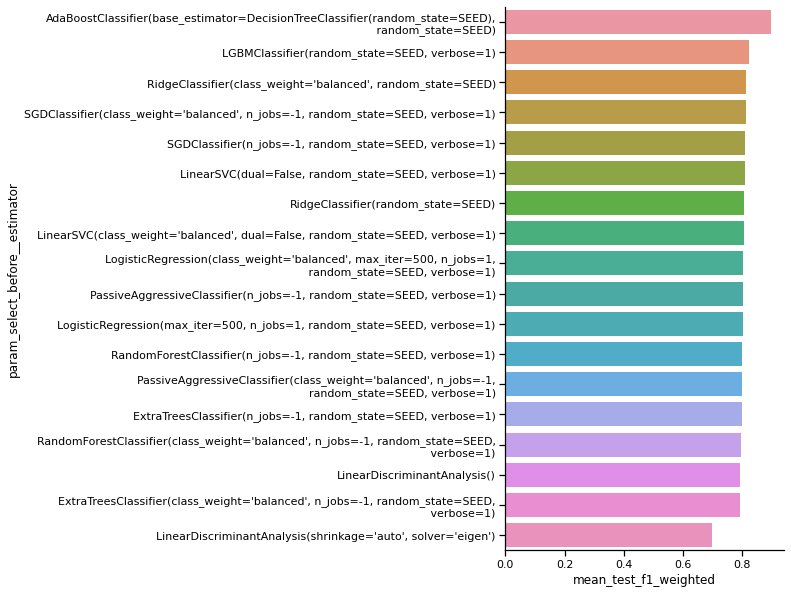

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


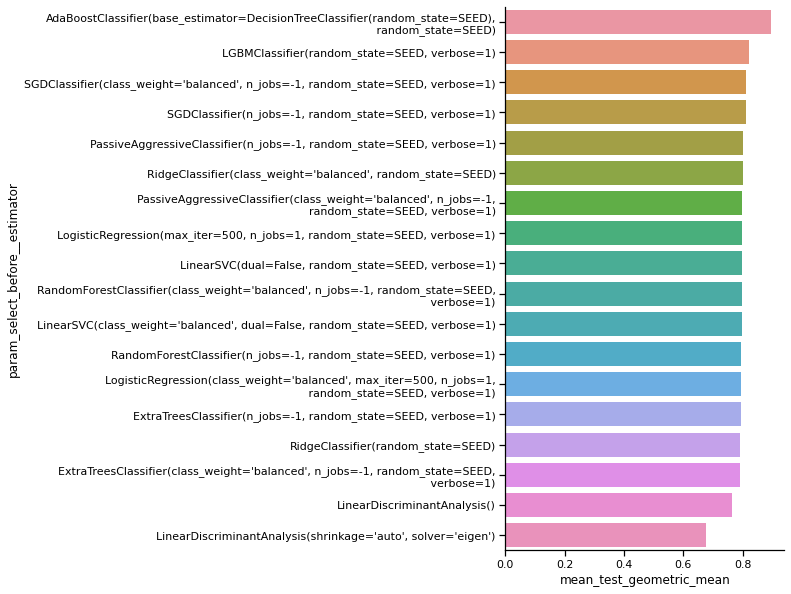

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


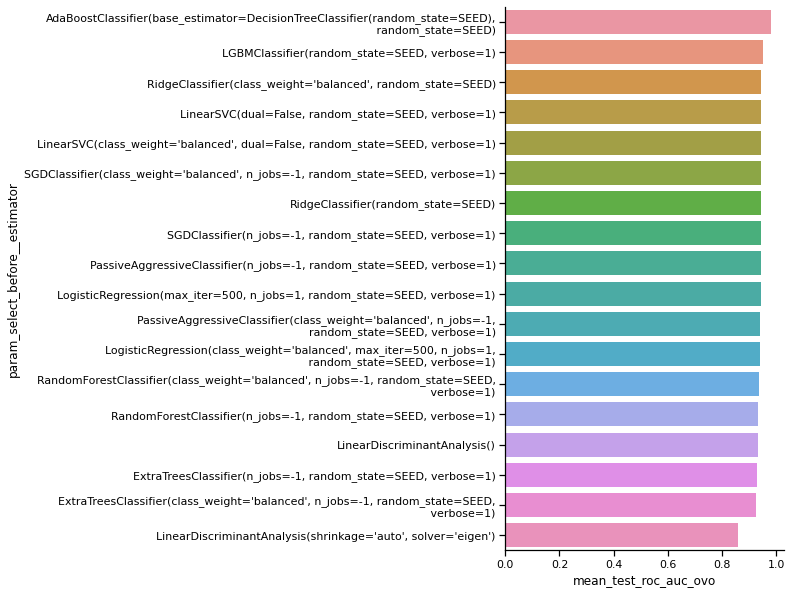

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


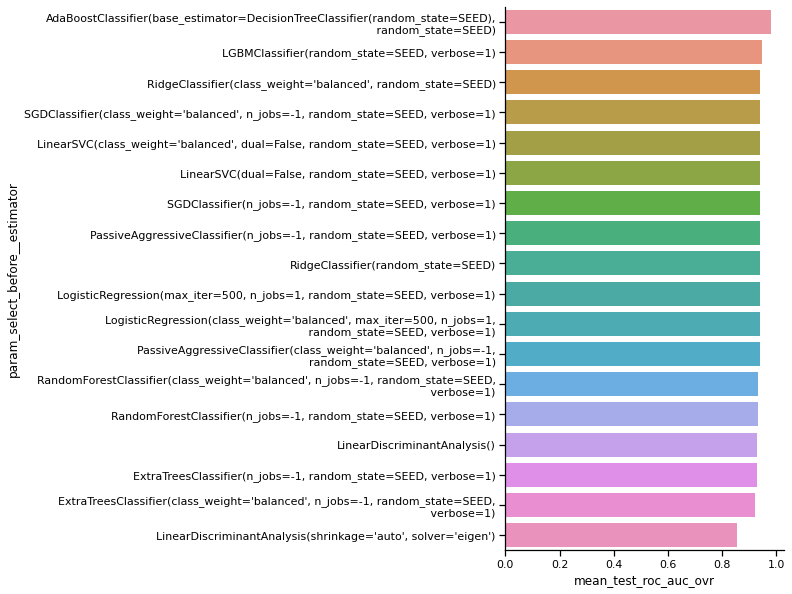

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


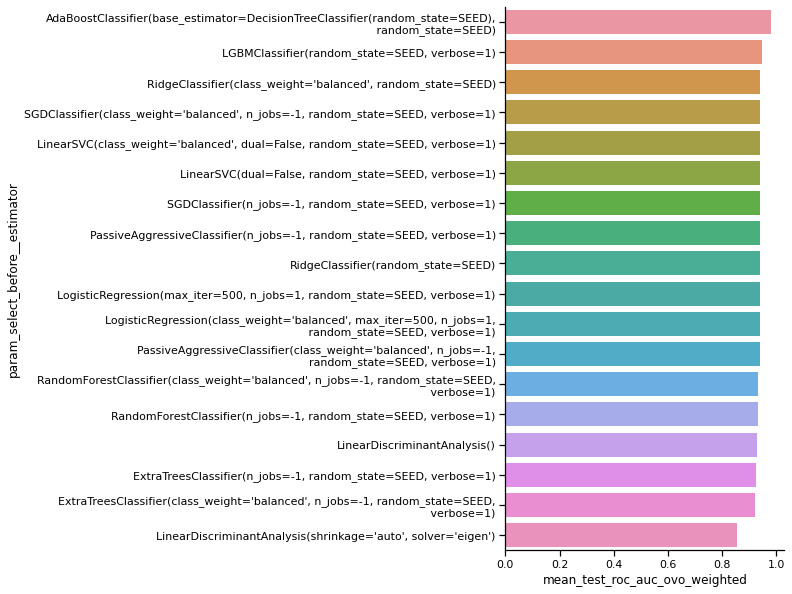

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


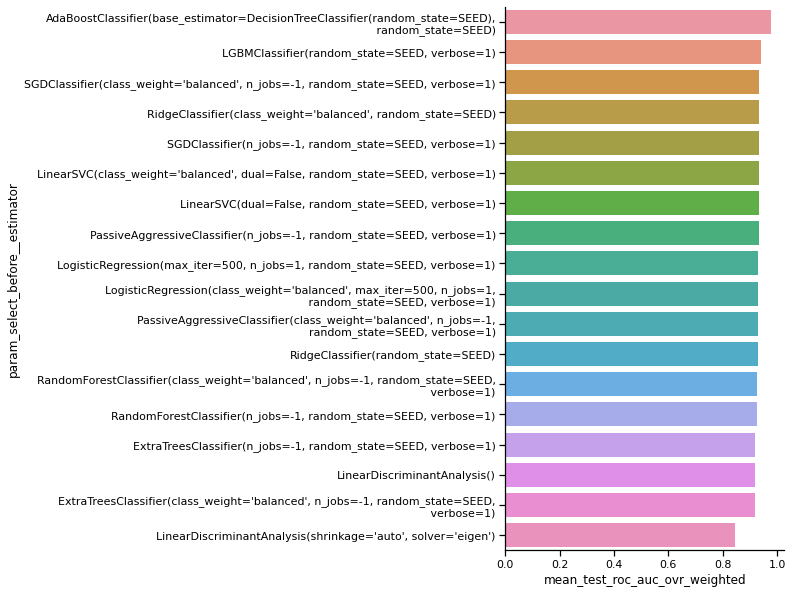

time: 3.3 s


In [88]:
for score in (
    "accuracy",
    "balanced_accuracy",
    "f1_weighted",
    "geometric_mean",
    "roc_auc_ovo",
    "roc_auc_ovr",
    "roc_auc_ovo_weighted",
    "roc_auc_ovr_weighted",
):
    plot_estimator_score(score, df_)

AdaBoostClassifier could be the best model for feature selection.

In [89]:
df_ = pd.concat(
    [
        pd.read_feather(
            f"{DATA_OUT_FOLDER}/cv_{fold_num}_results/GaussianNB_hypersearch.feather"
        )
        for fold_num in FOLDS
    ]
).reset_index(drop=True)
df_.loc[df_.param_clf.str.contains("random_state"), "param_clf"] = df_.loc[
    df_.param_clf.str.contains("random_state"),
    "param_clf",
].str.replace(r"202[1-5]", r"SEED")
df_ = df_.groupby("param_clf").mean()
df_ = df_.loc[df_.index != "nan"]
df_
df_.columns

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/1371193705.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_.loc[df_.param_clf.str.contains("random_state"), "param_clf"] = df_.loc[


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__base_estimator__var_smoothing,param_clf__var_smoothing,param_select_before__k,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_balanced_accuracy,split1_test_balanced_accuracy,split2_test_balanced_accuracy,split3_test_balanced_accuracy,split4_test_balanced_accuracy,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_test_geometric_mean,split1_test_geometric_mean,split2_test_geometric_mean,split3_test_geometric_mean,split4_test_geometric_mean,mean_test_geometric_mean,std_test_geometric_mean,rank_test_geometric_mean,split0_test_roc_auc_ovo,split1_test_roc_auc_ovo,split2_test_roc_auc_ovo,split3_test_roc_auc_ovo,split4_test_roc_auc_ovo,mean_test_roc_auc_ovo,std_test_roc_auc_ovo,rank_test_roc_auc_ovo,split0_test_roc_auc_ovr,split1_test_roc_auc_ovr,split2_test_roc_auc_ovr,split3_test_roc_auc_ovr,split4_test_roc_auc_ovr,mean_test_roc_auc_ovr,std_test_roc_auc_ovr,rank_test_roc_auc_ovr,split0_test_roc_auc_ovo_weighted,split1_test_roc_auc_ovo_weighted,split2_test_roc_auc_ovo_weighted,split3_test_roc_auc_ovo_weighted,split4_test_roc_auc_ovo_weighted,mean_test_roc_auc_ovo_weighted,std_test_roc_auc_ovo_weighted,rank_test_roc_auc_ovo_weighted,split0_test_roc_auc_ovr_weighted,split1_test_roc_auc_ovr_weighted,split2_test_roc_auc_ovr_weighted,split3_test_roc_auc_ovr_weighted,split4_test_roc_auc_ovr_weighted,mean_test_roc_auc_ovr_weighted,std_test_roc_auc_ovr_weighted,rank_test_roc_auc_ovr_weighted,fold_num
param_clf,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"BaggingClassifier(base_estimator=GaussianNB(), n_jobs=-1, random_state=SEED,\n verbose=1)",6.489184,0.824277,1.841268,0.416166,0.022819,NaN,26.193925,0.839243,0.812678,0.853719,0.773163,0.852664,0.826293,0.041886,265.062575,0.832903,0.805276,0.864200,0.803067,0.878370,0.836763,0.043423,222.205776,0.839875,0.811155,0.854547,0.776168,0.854021,0.827153,0.041845,260.944645,0.830914,0.799102,0.861516,0.793815,0.875605,0.832190,0.046447,221.229844,0.953518,0.941330,0.967509,0.926955,0.967713,0.951405,0.020427,241.346570,0.951192,0.937316,0.965069,0.922680,0.965078,0.948267,0.021486,241.956679,0.950538,0.937022,0.964448,0.921120,0.964983,0.947622,0.021719,242.767750,0.944520,0.929845,0.961179,0.912773,0.960890,0.941842,0.024111,246.125150,1.912154
"CalibratedClassifierCV(base_estimator=GaussianNB(), method='isotonic',\n n_jobs=-1)",5.098463,0.697729,1.372232,0.232715,0.023641,NaN,26.202326,0.837867,0.812402,0.871046,0.800051,0.874948,0.839263,0.040698,215.962500,0.801411,0.770044,0.848235,0.797339,0.883400,0.820086,0.051936,297.273864,0.834553,0.805455,0.869534,0.799969,0.875759,0.837054,0.042293,223.837500,0.794259,0.754353,0.843217,0.786523,0.882608,0.812192,0.057726,299.178409,0.948174,0.937175,0.965473,0.927624,0.968730,0.949435,0.021166,261.034091,0.946018,0.934221,0.963470,0.922993,0.966502,0.946641,0.022257,259.747727,0.945985,0.934073,0.962836,0.921898,0.966484,0.946255,0.022299,258.156818,0.942116,0.928951,0.959942,0.914257,0.962873,0.941628,0.024216,252.157955,2.072727
GaussianNB(),3.891155,0.480149,0.466318,0.118983,NaN,0.019559,27.197115,0.838677,0.813775,0.852688,0.772799,0.852413,0.826070,0.041733,270.784537,0.831992,0.806298,0.863857,0.803153,0.878503,0.836761,0.042997,225.263625,0.839317,0.812139,0.853616,0.775766,0.853816,0.826931,0.041722,266.381496,0.830027,0.799889,0.861245,0.793739,0.875738,0.832128,0.046184,224.167300,0.952814,0.941787,0.967262,0.926962,0.967570,0.951279,0.020217,246.695817,0.950429,0.937863,0.964779,0.922722,0.964868,0.948132,0.021244,247.472750,0.949740,0.937543,0.964173,0.921161,0.964764,0.947476,0.021481,248.403042,0

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_clf__base_estimator__var_smoothing', 'param_clf__var_smoothing',
       'param_select_before__k', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy', 'split0_test_balanced_accuracy',
       'split1_test_balanced_accuracy', 'split2_test_balanced_accuracy',
       'split3_test_balanced_accuracy', 'split4_test_balanced_accuracy',
       'mean_test_balanced_accuracy', 'std_test_balanced_accuracy',
       'rank_test_balanced_accuracy', 'split0_test_f1_weighted',
       'split1_test_f1_weighted', 'split2_test_f1_weighted',
       'split3_test_f1_weighted', 'split4_test_f1_weighted',
       'mean_test_f1_weighted', 'std_test_f1_weighted',
       'rank_test_f1_weighted', 'split0_test_geometric_mean',
       'split1_test_geometric_mean', 'split2_test_geo

time: 123 ms


C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


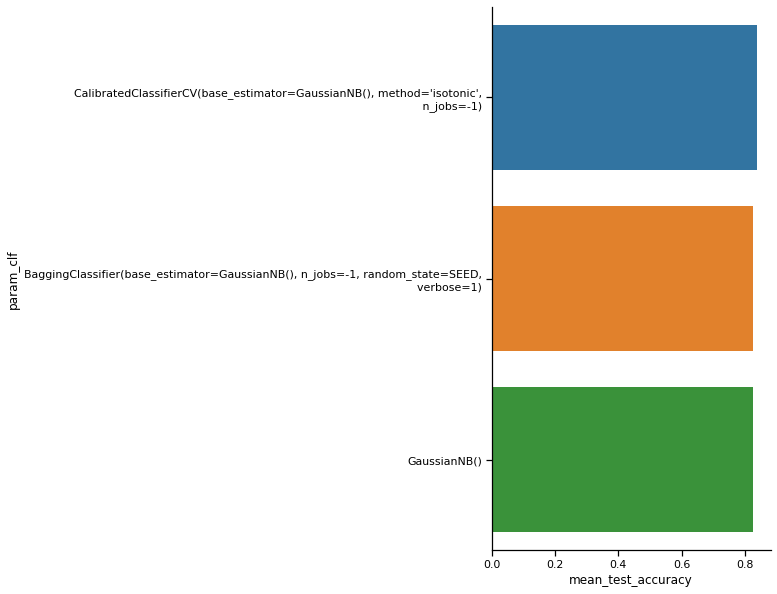

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


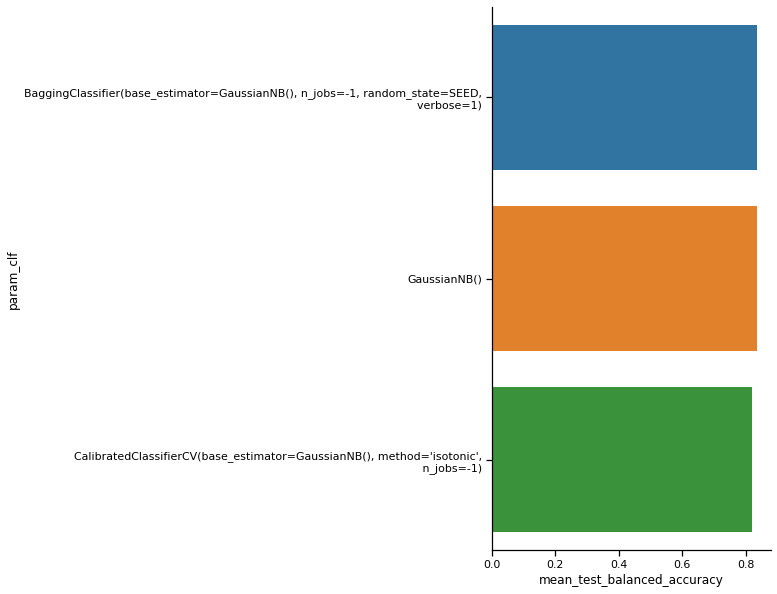

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


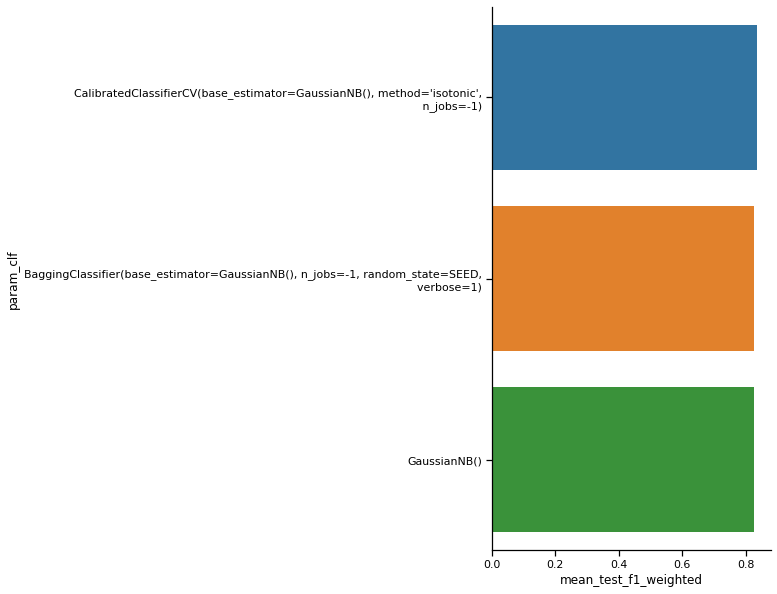

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


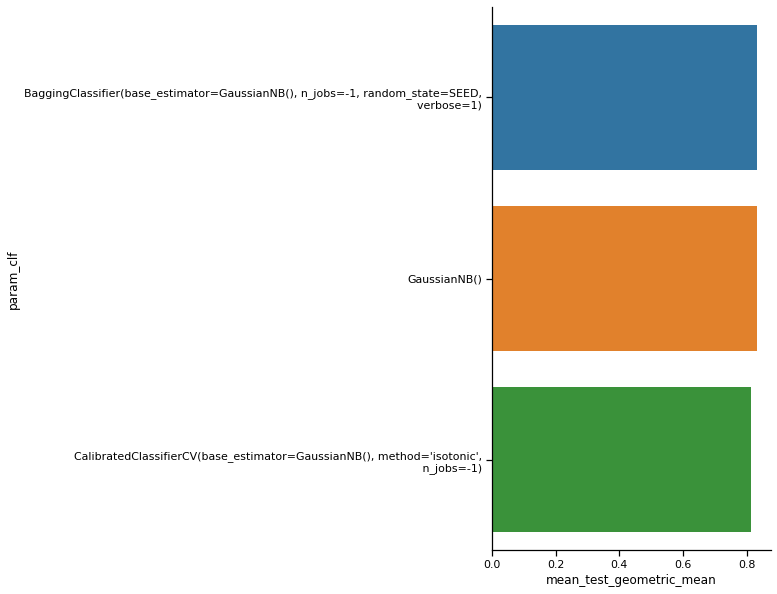

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


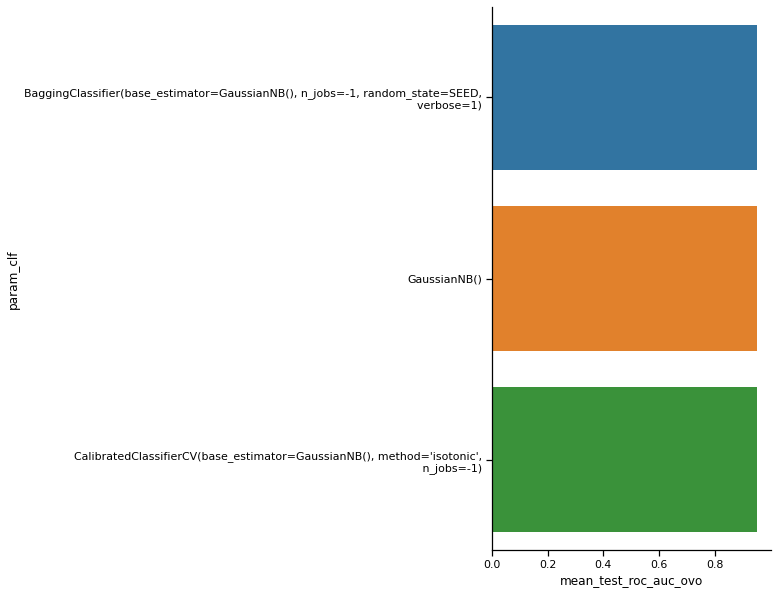

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


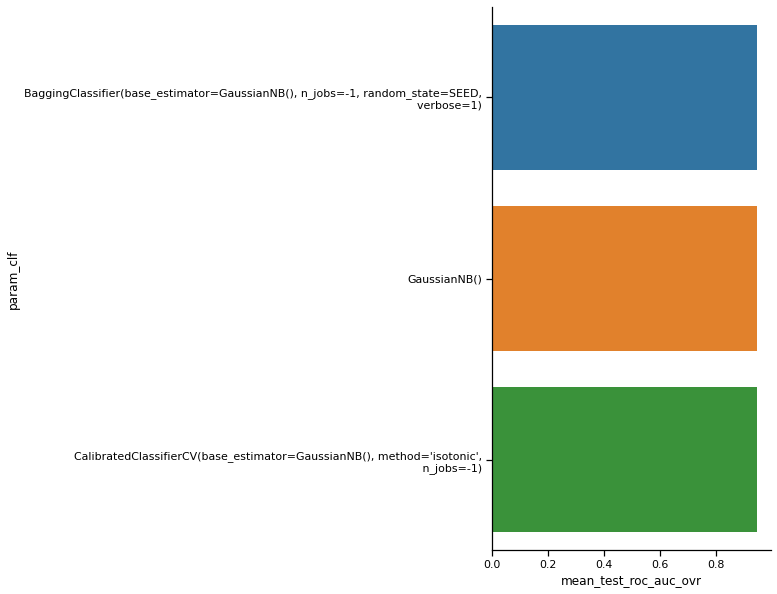

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


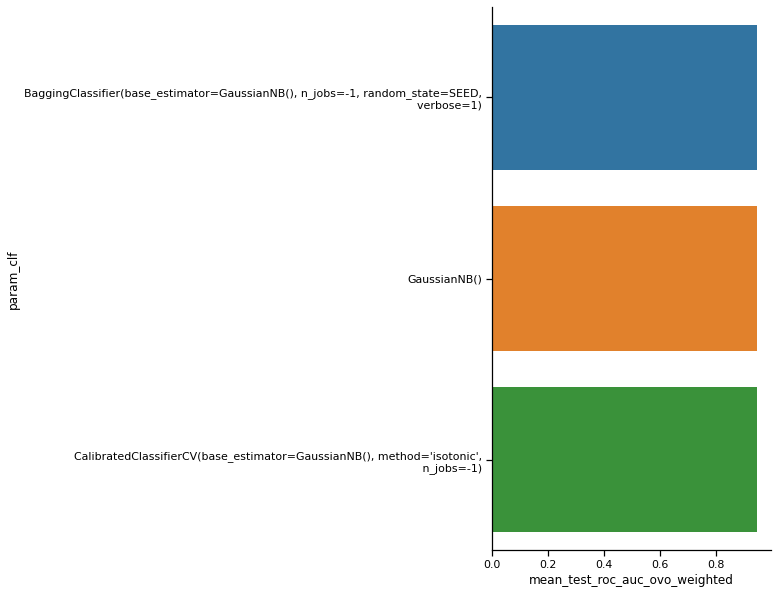

C:\Users\michen\AppData\Local\Temp/ipykernel_2236/492900813.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


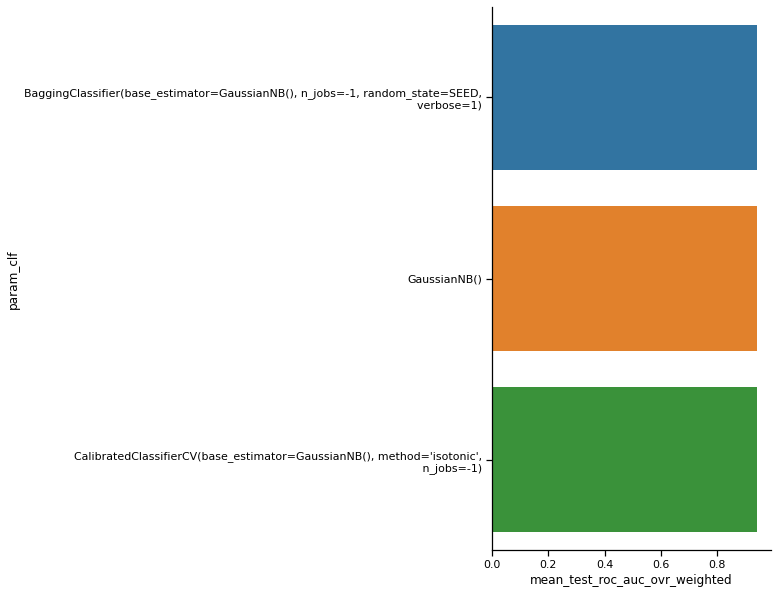

time: 1.43 s


In [90]:
for score in (
    "accuracy",
    "balanced_accuracy",
    "f1_weighted",
    "geometric_mean",
    "roc_auc_ovo",
    "roc_auc_ovr",
    "roc_auc_ovo_weighted",
    "roc_auc_ovr_weighted",
):
    plot_estimator_score(score, df_)

In [91]:
df_.loc[:, df_.columns.str.startswith("mean_test_")]

,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_f1_weighted,mean_test_geometric_mean,mean_test_roc_auc_ovo,mean_test_roc_auc_ovr,mean_test_roc_auc_ovo_weighted,mean_test_roc_auc_ovr_weighted
param_clf,,,,,,,,
"BaggingClassifier(base_estimator=GaussianNB(), n_jobs=-1, random_state=SEED,\n verbose=1)",0.826293,0.836763,0.827153,0.832190,0.951405,0.948267,0.947622,0.941842
"CalibratedClassifierCV(base_estimator=GaussianNB(), method='isotonic',\n n_jobs=-1)",0.839263,0.820086,0.837054,0.812192,0.949435,0.946641,0.946255,0.941628
GaussianNB(),0.826070,0.836761,0.826931,0.832128,0.951279,0.948132,0.947476,0.941672


time: 14 ms


no clear winner here